# SROP Winter 2025

### Dataset loading

In [17]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import tqdm
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torchsummary import summary
import struct

In [18]:
DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

In [19]:
train_dataset = torchvision.datasets.FashionMNIST(
    'data/', train=True, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)
test_dataset = torchvision.datasets.FashionMNIST(
    'data/', train=False, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

# Create a 10% validation set using stratification.
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_dataset)),
    train_dataset.targets,
    stratify=train_dataset.targets,
    test_size=0.1
)
train_split = Subset(train_dataset, train_indices)
val_split = Subset(train_dataset, val_indices)

# Update the training set transform to include data augmentation.
augment_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=0.05),
    torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])
train_split.dataset.transform = augment_transform

# Create DataLoader objects.
train_batch_size = 512
test_batch_size  = 256
train_batches = DataLoader(train_split, batch_size=train_batch_size, shuffle=True)
val_batches   = DataLoader(val_split, batch_size=train_batch_size, shuffle=True)
test_batches  = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

print("Number of training batches:", len(train_batches))
print("Number of validation batches:", len(val_batches))
print("Number of test batches:", len(test_batches))

Number of training batches: 106
Number of validation batches: 12
Number of test batches: 40


Data is now formatted and loaded.

In [20]:
def set_color(r, g, b, bg=False):
    """
    Sets the text or background color using RGB values.

    Args:
        r: Red value (0-255).
        g: Green value (0-255).
        b: Blue value (0-255).
        bg: If True, sets the background color; otherwise, sets the text color.
    """
    type = 48 if bg else 38
    print(f"\033[{type};2;{r};{g};{b}m", end="")

In [21]:
with open('data/FashionMNIST/raw/train-images-idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    # print(data.shape) # (47040000,)
    Xtraindata = data.reshape((size, nrows*ncols))

with open('data/FashionMNIST/raw/train-labels-idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    Ylabeldata = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    # print(data.shape) # (47040000,)

In [22]:
# imgIndex = 0

# for row in range(28):
#     for cell in range(28):
#         pixelBrightness = Xtraindata[imgIndex][row*28+cell]
#         set_color(pixelBrightness,pixelBrightness,pixelBrightness,True)
#         print(' * ',end='')
#     print()
# print(Ylabeldata[imgIndex])

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=70)
reduced_data = pca.fit_transform(Xtraindata)


In [33]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10,random_state=1).fit(reduced_data)
cluster_centers = np.transpose(kmeans.cluster_centers_)[:2]


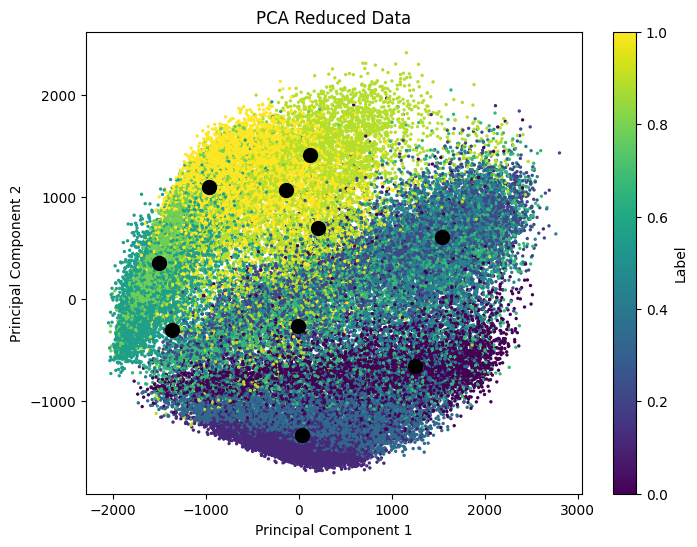

In [37]:
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=Ylabeldata, cmap='viridis', s=2)
plt.scatter(cluster_centers[0],cluster_centers[1],s=100,c='black')
plt.colorbar(label='Label')
plt.title('PCA Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Now, let's evaluate the accuracy.

In [ ]:
predicted_labels = kmeans.fit_predict(reduced_data)

# AI code to evaluate how well I did

# Count elements in each cluster
unique_clusters, counts = np.unique(predicted_labels, return_counts=True)
print("\nCluster distribution:")
for cluster, count in zip(unique_clusters, counts):
    print(f"Cluster {cluster}: {count} samples")

# Check how the clusters align with actual labels
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
print(f"\nAdjusted Rand Index: {adjusted_rand_score(Ylabeldata, predicted_labels):.4f}")
print(f"Normalized Mutual Information: {normalized_mutual_info_score(Ylabeldata, predicted_labels):.4f}")

# Show majority class in each cluster
print("\nDominant label in each cluster:")
totPer = 0
for cluster_id in range(10):
    cluster_indices = np.where(predicted_labels == cluster_id)[0]
    cluster_labels = Ylabeldata[cluster_indices]
    unique_labels, label_counts = np.unique(cluster_labels, return_counts=True)
    dominant_label = unique_labels[np.argmax(label_counts)]
    percentage = np.max(label_counts) / len(cluster_indices) * 100
    totPer+=percentage
    print(f"Cluster {cluster_id}: dominant class {dominant_label} ({percentage:.2f}%)")


Cluster distribution:
Cluster 0: 3714 samples
Cluster 1: 7978 samples
Cluster 2: 4408 samples
Cluster 3: 9105 samples
Cluster 4: 7725 samples
Cluster 5: 8034 samples
Cluster 6: 5077 samples
Cluster 7: 5817 samples
Cluster 8: 3808 samples
Cluster 9: 4334 samples

Adjusted Rand Index: 0.3967
Normalized Mutual Information: 0.5326

Dominant label in each cluster:
Cluster 0: dominant class 8 (93.30%)
Cluster 1: dominant class 6 (25.02%)
Cluster 2: dominant class 3 (77.02%)
Cluster 3: dominant class 4 (37.39%)
Cluster 4: dominant class 7 (66.07%)
Cluster 5: dominant class 5 (48.76%)
Cluster 6: dominant class 1 (99.35%)
Cluster 7: dominant class 9 (86.40%)
Cluster 8: dominant class 0 (79.67%)
Cluster 9: dominant class 3 (38.90%)
totPer 65.18740475574148


In [27]:
with open('data/FashionMNIST/raw/t10k-images-idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    # print(data.shape) # (47040000,)
    Xtestdata = np.transpose(data.reshape((size, nrows*ncols)))

with open('data/FashionMNIST/raw/t10k-labels-idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    Ytestlabel = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    # print(data.shape) # (47040000,)